Analyzing Possible Determinants to Predict Newsletter Subscription Status Through Minecraft Player Data 

Group 29 Dsci members: Nicholas Hong, Ethan Yu, Arav Bubna, Kian Shahnia


Introduction: 
Data from a minecraft server was monitored and provided to DSCI 100 by Frank Wood, who leads a UBC research group in Computer Science. The broad question that the data needs to answer is “which player characteristics and behaviors are most likely to predict if a player will subscribe to a game-related newsletter, and if these features differ between various player types”. 

Based on this broad question, the specific question our group is trying to answer is “can player experience level, total hours played, age, and gender predict subscription status in the UBC Minecraft dataset?” Through sorting, analysis, and interpretation we aim to identify possible reasons and relationships within the data and present our conclusions.

We have access to two datasets: players.csv and sessions.csv. Players.csv contains data on player experience, subscription status, hashed email, hours played, name, gender, and age. Sesssions.csv contains data on player hashed email, session start times, end times, and when they originally started and stopped playing on the server. 

Potential issues in the data include: 

-Not being able to account for true active playtime. In Minecraft a player can be idle (AFK) without doing anything and using minimal resources on a server and the data given cannot account for this. 

-There are also many players with playtimes of near 0 which may skew some of the visualizations if they are not removed. 

-Some rows of player data may be missing one or more variables we are using to visualize our relationships which will need to be removed. Specifically values involving end time and original end time 

-The data concerning date and session times need to be converted and altered to be humanly readable. 

-Certain variables may need to be converted to categorical ones for proper visualization. 

Coding/Methods: 
Some things to make note of concerning the data: 

-experience and gender should be stored as categorical instead of character variables

-all times need to be converted into the datetime format

-original_start_time & original_end_time (double) likely represent a Unix timestamp. This is a common way of storing dates and times as the number of seconds (or milliseconds) since January 1, 1970 (UTC).

-there is no usage of the name column because hashed email serves as an identifier for session start and end times 

-we will need to use as_factor to convert class type variables to factors for classification

We are visualizing: 
experience , age, total hours played, gender 



How we started coding and visualization: 

We loaded the player and session data into jupyter then converted the necessary variables into factors using as_factor to use classification. Through this we can now use the numerical and categorical variables to visualize if there is any relationship to subscription status. We started by visualizing age vs hours played to demonstrate if there is a relationship. At certain ages, players typically have more time to spend on gaming, so  they may have a higher subscription rate to newsletters. Next, we visualized each experience level to show their relationship to subscription status by seeing how many players at each experience level are subscribed to see if there is a relationship.







In [1]:
library(tidyverse)
library(dplyr)
library(knitr)
library(ggplot2)
library(tidymodels)
library(themis)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Method and Results

### Reading/Wrangling Data

In [2]:
players <- read_csv("data/players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Factorized categorical variables (`gender`, `experience`, `subscribe`)

In [3]:
players <- players |>
  mutate(
    gender = as_factor(gender),
    experience = as_factor(experience),
    subscribe = as_factor(subscribe)
  )


Used Median Based Imputation to remove N/A values from `Age`

In [4]:
players <- players |> mutate(Age = ifelse(is.na(Age), median(Age, na.rm = TRUE), Age))

Removed unused columns (`name`, `hashedEmail`)

In [5]:
players <- players |> select(-name, -hashedEmail)

### Classification

Binarize categorical variables

Split into training and testing

In [6]:
set.seed(123)
players_split <- initial_split(players, strata = subscribe)
players_train <- training(players_split)
players_test  <- testing(players_split)

Define Recipe. Upsampling is required as there are many more `TRUE` entries than `FALSE`

In [7]:
knn_recipe <- recipe(subscribe ~ played_hours + experience + Age + gender, data = players_train) |>
  step_dummy(all_nominal_predictors()) |>
  step_zv(all_predictors()) |>
  step_normalize(all_predictors()) |>
  step_upsample(subscribe, over_ratio = 1, skip = TRUE)

Create resampling folds for cross-validation

In [8]:
set.seed(123)
players_folds <- vfold_cv(players_train, v = 5, strata = subscribe)

Define a k-NN specification

In [9]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

Combine recipe and model into a workflow

In [10]:
knn_workflow <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec) 

Create a grid of possible k values

In [11]:
k_grid <- tibble(neighbors = seq(1, 25, by = 1))

Tune over the grid using cross-validation, check tuning metrics and pull the best K value based on accuracy

[1] 1

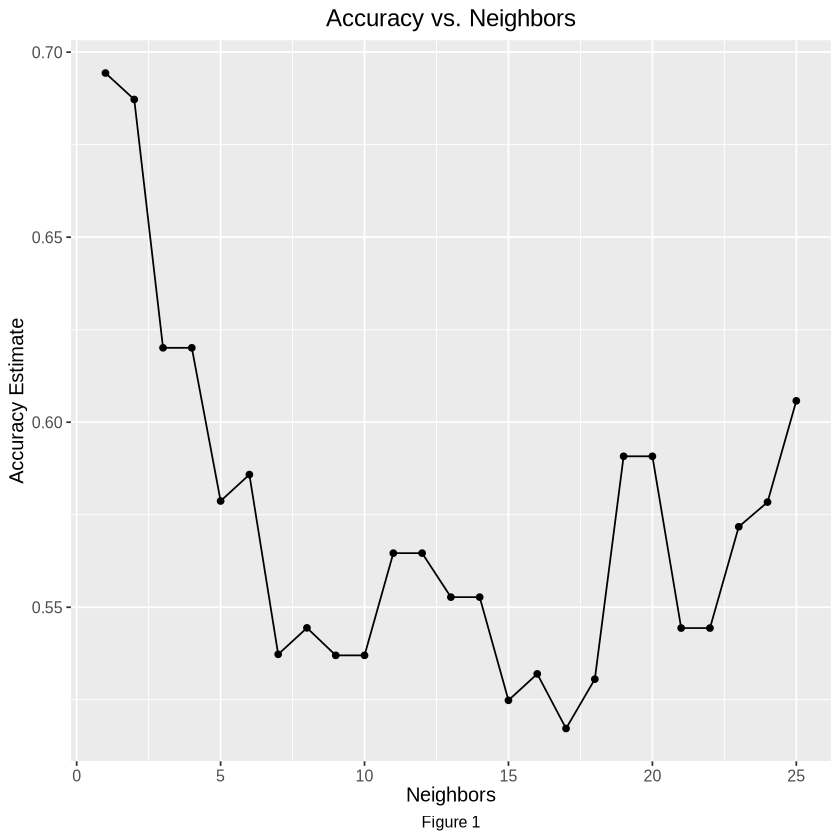

In [17]:
knn_tune_results <- knn_workflow |>
  tune_grid(resamples = players_folds,
                 grid = k_grid,
              control = control_grid(save_pred = FALSE)) |>
                collect_metrics(event_level = "second")

accuracies <- knn_tune_results |>
  filter(.metric == "accuracy")

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)

best_k

accuracy_vs_k_lots <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy vs. Neighbors", caption = "Figure 1") +
  theme(text = element_text(size = 12),     
        plot.title = element_text(hjust = 0.5),
    plot.caption = element_text(hjust = 0.5))

accuracy_vs_k_lots

Based on the value we pulled and what we can see on the plot, `K = 1` will provide the highest accuracy

Now we can finalize the model,

In [13]:
knn_recipe <- recipe(subscribe ~  played_hours + experience + Age + gender, data = players_train) |>
  step_dummy(all_nominal_predictors()) |>
  step_zv(all_predictors()) |>
  step_normalize(all_predictors()) |>
  step_upsample(subscribe, over_ratio = 1, skip = TRUE)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
      set_engine("kknn") |>
      set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_train)

And access its accuracy (we set `event_level` to "second" in order to make sure that we are checking for who does subscribe rather than does not

In [14]:
players_test_predictions <- predict(knn_fit, players_test) |>
  bind_cols(players_test)

players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_test_predictions |>
  precision(truth = subscribe, estimate = .pred_class, event_level = "second") 

players_test_predictions |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "second") 

confusion <- players_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class, event_level = "second")
confusion


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6530612


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7435897


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.8055556


Warning message:
“The `...` argument of `conf_mat()` was deprecated in yardstick 1.0.0.
ℹ This argument no longer has any effect, and is being ignored.
ℹ The deprecated feature was likely used in the yardstick package.
  Please report the issue at <https://github.com/tidymodels/yardstick/issues>.”


          Truth
Prediction FALSE TRUE
     FALSE     3    7
     TRUE     10   29

We can also run the following to check if our code is overfitting or underfitting

In [15]:
train_predictions <- predict(knn_fit, players_train) |>
  bind_cols(players_train)

train_metrics <- train_predictions |>
  metrics(truth = subscribe, estimate = .pred_class)

cat("Training set performance\n")
train_metrics

test_predictions <- predict(knn_fit, players_test) |>
  bind_cols(players_test)

test_metrics <- test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class)

cat("\nTest set performance\n")
test_metrics

Training set performance


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9387755
kap,binary,0.8467153



Test set performance


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.65306122
kap,binary,0.03921569


Based on these results, it is clear that our model is overfitting, as the accuracy drops significantly from the training set to the test set

DISCUSSION

Summary:
We found that our model had poor results in predicting if a player would be subscribed to a newsletter a lot, based on player experience, age and subscription status. This suggests that there may be a lack of relationship between the variables involved (age and hours played, experience level and subscription status)
 
We expected to find a relationship between age and hours played as certain ages may typically have more time to play video games due to more free time. As players have more time to spend on gaming, they may have a higher subscription rate to newsletters. Additionally, we also expected to find a correlation between the experience levels and the subscription status of players, specifically if players of different experience levels have differences or similarities in the number of players subscribed to newsletters. Our thinking was that higher experience levels may imply a larger time investment in the game and therefore making them more likely to have increased interest or investment in game related newsletters. 

Our findings suggest that age, experience levels, and hours played are irrelevant to if an individual chooses to subscribe to a newsletter or not. As a result, future research into determining if players would subscribe to a newsletter should be based on different variables. 

Future questions that could be derived from our findings could be determining variables in the newsletters themselves, by determining the content and features of a newsletter that may attract readers. Alternatively, different variables, such as reading habits by players could be used to determine a correlation to subscription rates. 
